# Observations sismiques de la graine: premiers pas

En utilisant la librairie TauP incluse dans Obspy (en Python, donc), nous allons voir comment on peut mettre en évidence l'existence de la graine et comment on l'observe. Version de Python utilisée : 3.5

Le début du tutoriel est librement inspiré et traduit de la documentation de Obspy.taup, disponible ici: https://docs.obspy.org/packages/obspy.taup.html

Ce notebook mélange explications et code python. 

In [31]:
%matplotlib inline 
#les figures s'affichent dans le notebook

# import statements
import numpy as np 
import matplotlib.pyplot as plt #for figures
from matplotlib.animation import FuncAnimation #for animations
from IPython.display import HTML

from obspy.taup import TauPyModel #TauP

Sous TauP, il faut commencer par initialiser le modèle. Chacun de ces modèles sont radiaux: on ne peux donc pas observer d'anisotropie ou d'hétérogénéités latérales, mais on peut mettre en évidence les méthodes d'observations et comprendre les résultats des observations sismiques.

In [2]:
model = TauPyModel(model="iasp91")

TauP nous permet de calculer le temps d'arrivée théorique d'une phase sismique à une station donnée (définie uniquement par l'angle entre la position du séisme et la station). Dans les figures, le séisme est indiqué par une étoile, et située en haut de la figure. 

In [3]:
source_depth = 100 #profondeur du séisme en km.

### Exemple d'utilisation de TauP:

Les deux fonctions principales que l'on peut utiliser sont get_travel_times() et get_ray_paths(), qui prennent chacun les memes arguments: la profondeur du séisme, l'angle entre la source et la station, et (non obligatoire) les phases qui vous intéressent, données sous forme d'une liste de texte, avec le formattage habituel des phases sismiques (par exemple ['P', 'PKS', 'PKKP']

get_travel_times calcule simplement les temps d'arrivées des différentes phases, alors que get_ray_paths calcule en plus les trajectoires exactes des rays. Si une phase n'arrive pas à la station en question, alors la taille de la liste en sortie peut etre nulle. 

In [4]:
arrivals = model.get_travel_times(source_depth_in_km=source_depth,
                                  distance_in_degree=70,
                                  phase_list=["P", "PP", 'PKP'])
print(arrivals)

2 arrivals
	P phase arrival at 660.774 seconds
	PP phase arrival at 816.594 seconds


(ici, la phase PKP n'arrive pas à la station, et n'est pas présente en sortie)

La fonction get_ray_paths() donne en apparence la meme sortie:

In [5]:
arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                  distance_in_degree=70,
                                  phase_list=["P", "PP", "PKP"])
print(arrivals)
print(type(arrivals[0].path[1][1]))
dt = np.dtype('float64, float64,float64,float64')
trajectory = np.asarray(arrivals[0].path, dtype=dt)
#print(trajectory)

def depth(arrival): #arrival is an Arrival instance
    length = len(arrival.path)
    _depth = np.zeros(length)
    for i, tupple in enumerate(arrival.path):
        _depth[i] = tupple[3]
    return max(_depth)

print("Les rais des phases P et PP vont respectivement jusque les profondeurs {} et {} km.".format(depth(arrivals[0]), depth(arrivals[1]))
   ) 

2 arrivals
	P phase arrival at 660.774 seconds
	PP phase arrival at 816.594 seconds
<class 'numpy.float64'>
Les rais des phases P et PP vont respectivement jusque les profondeurs 1918.1040295875564 et 848.6302129766846 km.


Chaque trajectoire est disponible dans arrivals. Par exemple, arrivals[0] est une instance Arrival, qui contient une variable "path", contenant les positions des différents points de la trajectoire. La variable path contient une liste de tuples, et pour chaque tuple, la seconde valeure est le temps, et la quatrième la profondeur.

On a définit ici une fonction depth, qui va chercher la profondeur maximum atteinte par le rai.

On peut ensuite appliquer la fonction plot() sur arrivals, et visualiser toutes les trajectoires (attention, on ne peut pas facilement en visualiser une seule!):

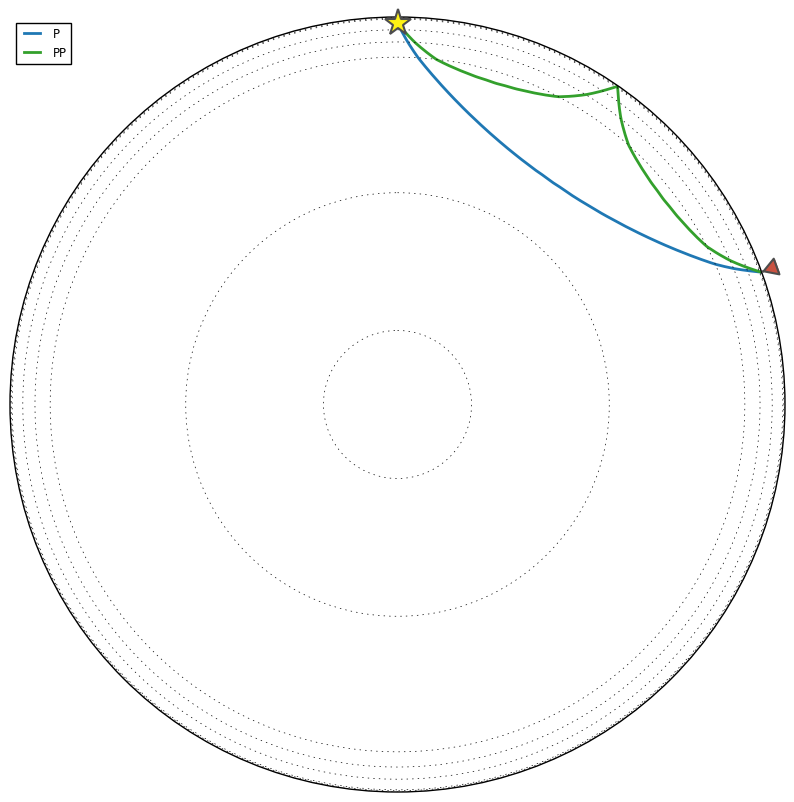

In [6]:
arrivals.plot()

Ici, on peut aussi ajouter sur la meme figure plusieurs phases, plusieurs stations, et quelques annotations!

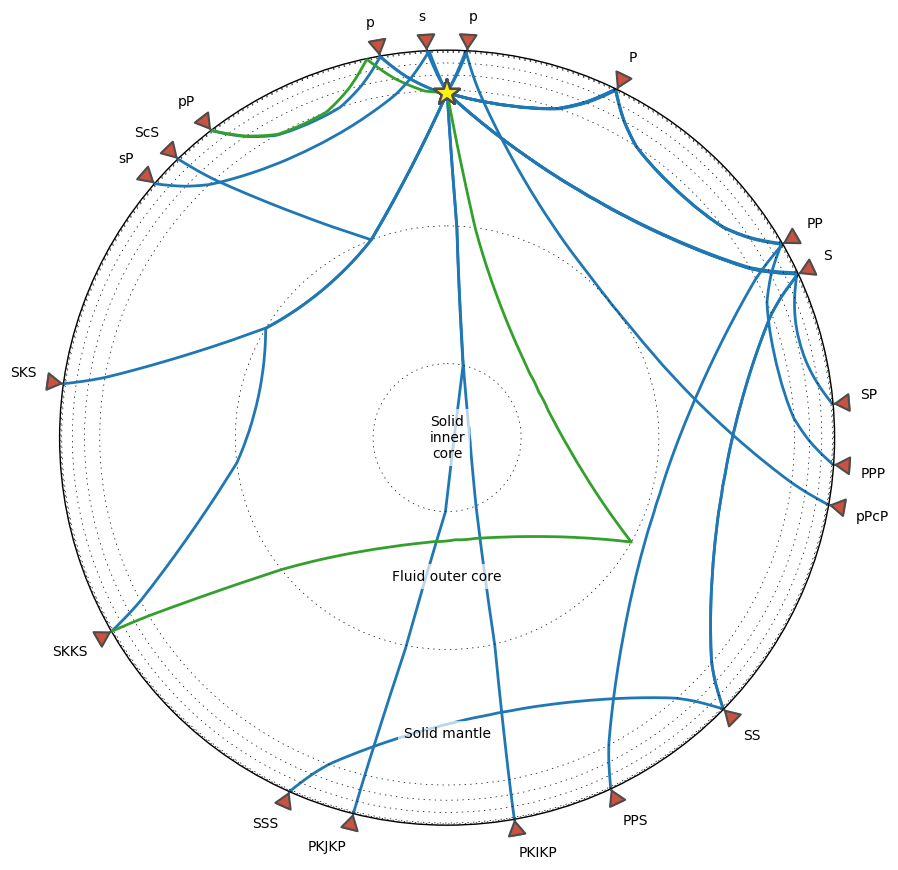

In [7]:
PHASES = [
    # Phase, distance
    # Right half
    ('P', 26),
    ('PP', 60),
    ('PPP', 94),
    ('PPS', 155),
    ('p', 3),
    ('pPcP', 100),
    ('PKIKP', 170),
    ('PKJKP', 194),
    ('S', 65),
    ('SP', 85),
    ('SS', 134.5),
    ('SSS', 204),
    # Left half
    ('p', -10),
    ('pP', -37.5),
    ('s', -3),
    ('sP', -49),
    ('ScS', -44),
    ('SKS', -82),
    ('SKKS', -120),
]

PLOT_ALL = [
    'SKKS',
]


model = TauPyModel(model='iasp91')
phase_name_radius = model.model.radius_of_planet * 1.1

# ax_right is used for paths plotted on the right half.
fig, ax_right = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax_right.set_theta_zero_location('N')
ax_right.set_theta_direction(-1)
# ax_left is used for paths plotted on the left half.
ax_left = fig.add_axes(ax_right.get_position(), projection='polar',
                       label='twin', frameon=False)
ax_left.set_theta_zero_location('N')
ax_left.set_theta_direction(+1)
ax_left.xaxis.set_visible(False)
ax_left.yaxis.set_visible(False)

# Plot all pre-determined phases
for phase, distance in PHASES:
    if distance < 0:
        realdist = -distance
        ax = ax_left
    else:
        realdist = distance
        ax = ax_right

    arrivals = model.get_ray_paths(700, realdist, phase_list=[phase])
    if not len(arrivals):
        print('FAIL', phase, distance)
        continue
    arrivals.plot(plot_type='spherical', plot_all=phase in PLOT_ALL,
                  legend=False, label_arrivals=True,
                  show=False, ax=ax)

# Annotate regions
ax_right.text(0, 0, 'Solid\ninner\ncore',
              horizontalalignment='center', verticalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
ocr = (model.model.radius_of_planet -
       (model.model.s_mod.v_mod.iocb_depth +
        model.model.s_mod.v_mod.cmb_depth) / 2)
ax_right.text(np.deg2rad(180), ocr, 'Fluid outer core',
              horizontalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
mr = model.model.radius_of_planet - model.model.s_mod.v_mod.cmb_depth / 2
ax_right.text(np.deg2rad(180), mr, 'Solid mantle',
              horizontalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

## La graine?

Maintenant, voyons comment mettre en évidence l'existence de la graine à partir de ces informations. Nous pourrions créer un modèle TauP sans graine, et comparer avec un modèle plus moderne. Mais ici, nous allons nous servir des noms des phases pour étudier les différentes ondes P et la répartition de leur détection aux différentes stations sismiques.

### Ondes P seules

L'argument principal pour l'existence d'un noyau liquide (ou du moins, l'existence d'une interface à 3600km de profondeur), c'est l'existence d'une zone d'ombre pour les ondes P. Pour le voir, on peut tracer les trajectoires des ondes P dans la graine, pour différentes stations sismiques.

La dernière observation d'onde ['S'] était à la station 96.73469387755102 degrés.
Pas de détection d'onde ['S'] à la station située à 100.20408163265306 degrés.
Pas de détection d'onde ['S'] à la station située à 103.67346938775509 degrés.
Pas de détection d'onde ['S'] à la station située à 107.14285714285714 degrés.
Pas de détection d'onde ['S'] à la station située à 110.61224489795919 degrés.
Pas de détection d'onde ['S'] à la station située à 114.08163265306122 degrés.
Pas de détection d'onde ['S'] à la station située à 117.55102040816325 degrés.
Pas de détection d'onde ['S'] à la station située à 121.0204081632653 degrés.
Pas de détection d'onde ['S'] à la station située à 124.48979591836735 degrés.
Pas de détection d'onde ['S'] à la station située à 127.95918367346938 degrés.
Pas de détection d'onde ['S'] à la station située à 131.42857142857142 degrés.
Pas de détection d'onde ['S'] à la station située à 134.89795918367346 degrés.
Pas de détection d'onde ['S'] à la station située 

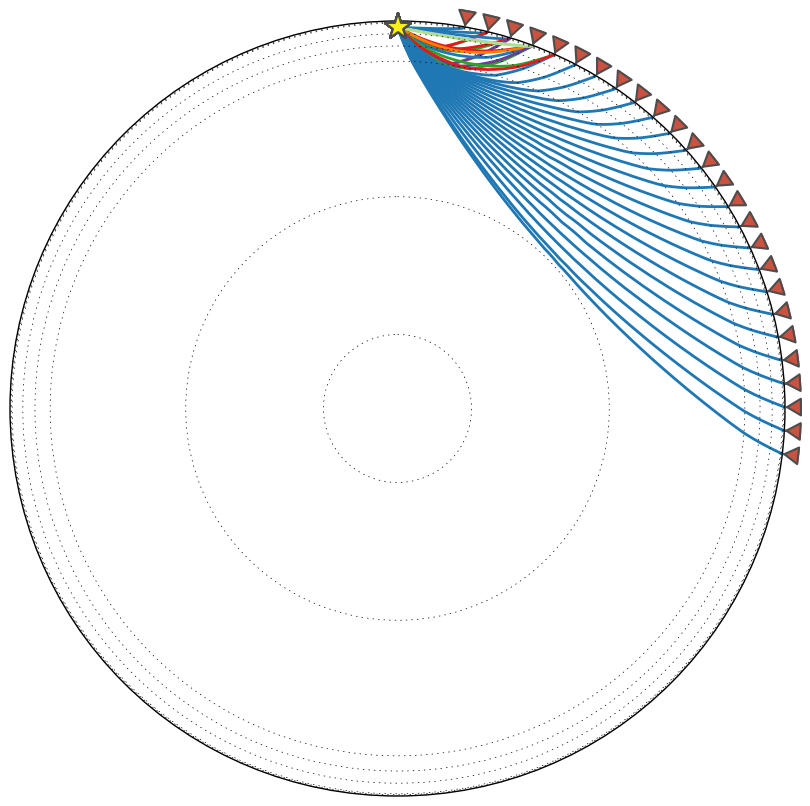

In [8]:
distances = np.linspace(10, 180, 50)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
phases = ['S']

last=False
for i, value in enumerate(distances):
    arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                   distance_in_degree=value,
                                   phase_list=phases)
    if len(arrivals)==0:
        if last == False:
            last = True
            print("La dernière observation d'onde {} était à la station {} degrés.".format(phases,distances[i-1]))
        print("Pas de détection d'onde {} à la station située à {} degrés.".format(phases, value))
        continue
    arrivals.plot(plot_type='spherical',
                  legend=False, 
                  label_arrivals=False,
                  show=False, ax=ax)

On voit plusieurs choses sur cette figure. Tout d'abord, aux stations proches de la source, les variations de vitesses sismiques dans le manteau supérieur génère plusieurs arrivées d'ondes P susccessives. En s'éloignant, ces effets sont plus faibles et indétectables. Ensuite, pour des angles supérieurs à environ 96 degrés, les stations sismiques ne détectent plus d'arrivées d'onde P: la profondeur du turning point devrait marquer environ la profondeur du noyau terrestre!

In [9]:
arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                   distance_in_degree=98,
                                   phase_list=phases)
print("Le rai arrivé à la station 98 degrés a plongé jusque {}km. Pour référence, le noyau terrestre dans ce modèle est à la profondeur de {}km.".format(depth(arrivals[0]), model.model.s_mod.v_mod.cmb_depth))

Le rai arrivé à la station 98 degrés a plongé jusque 2857.6103801004324km. Pour référence, le noyau terrestre dans ce modèle est à la profondeur de 2889.0km.


(L'erreur peut etre due soit à la position de la station, soit à l'échantillonnage de la trajectoire, qui n'est pas forcément adéquat au niveau de la CMB.

### Et si on rajoute les ondes PKP?

En rajoutant les ondes PKP, qui traversent le noyau, on voit de suite l'existence de la "zone d'ombre": Les ondes P sont réfractées et réfléchies à la CMB, et des stations situées plus loin (distance epicentrale > 145 environ) vont recevoir les ondes PKP, réfractées deux fois à la CMB. On peut aussi regarder les ondes S, qui sont des ondes de cisaillement, et qui ne se propagent pas dans la partie liquide. Une partie de l'énergie des ondes S à la CMB peut etre réfractée en tant qu'onde P à la CMB, et sortir en tant que SKS ou SKP par exemple, mais l'énergie continue dans la phase arrivant à la station sera très faible comparée à une onde S théorique traversant la terre.  

La dernière observation d'onde P était à la station 96.73469387755102 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 100.20408163265306 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 103.67346938775509 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 107.14285714285714 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 110.61224489795919 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 114.08163265306122 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 117.55102040816325 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 121.0204081632653 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 124.48979591836735 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 127.95918367346938 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 131.42857142857142 degrés.
Pas de détection d'onde ['P', 'PKP'] à la station située à 134.

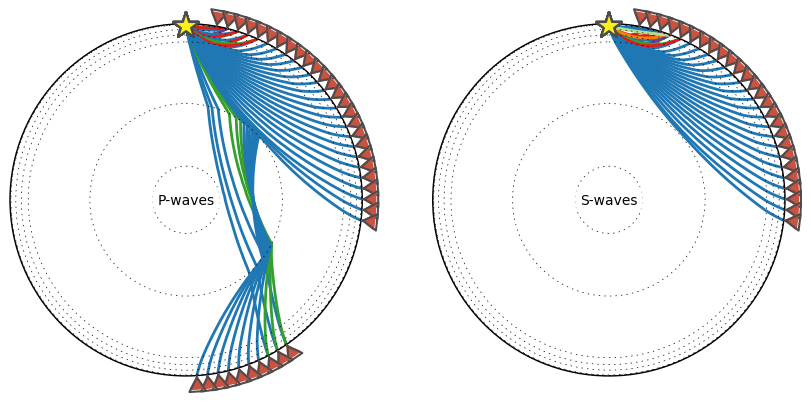

In [10]:
distances = np.linspace(10, 180, 50)
fig, ax = plt.subplots(1,2,figsize=(10, 10), subplot_kw=dict(polar=True))
ax[0].set_theta_zero_location('N')
ax[0].set_theta_direction(-1)
ax[1].set_theta_zero_location('N')
ax[1].set_theta_direction(-1)
phases = ['P', 'PKP']

last=False
for i, value in enumerate(distances):
    arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                   distance_in_degree=value,
                                   phase_list=phases)
    if len(arrivals)==0:
        if last == False:
            last = True
            print("La dernière observation d'onde P était à la station {} degrés.".format(distances[i-1]))
        print("Pas de détection d'onde {} à la station située à {} degrés.".format(phases, value))
        continue
    arrivals.plot(plot_type='spherical',
                  legend=False, 
                  label_arrivals=False,
                  show=False, ax=ax[0])
    
for i, value in enumerate(distances):
    arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                   distance_in_degree=value,
                                   phase_list=['S']) #no shear waves can go through the liquid core.
    if len(arrivals)==0: continue
    arrivals.plot(plot_type='spherical',
                  legend=False, 
                  label_arrivals=False,
                  show=False, ax=ax[1])
    
ax[0].text(0, 0, 'P-waves',
              horizontalalignment='center', verticalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
ax[1].text(0, 0, 'S-waves',
              horizontalalignment='center', verticalalignment='center',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

### Tracer les temps d'arrivée en fonction de la distance épicentrale

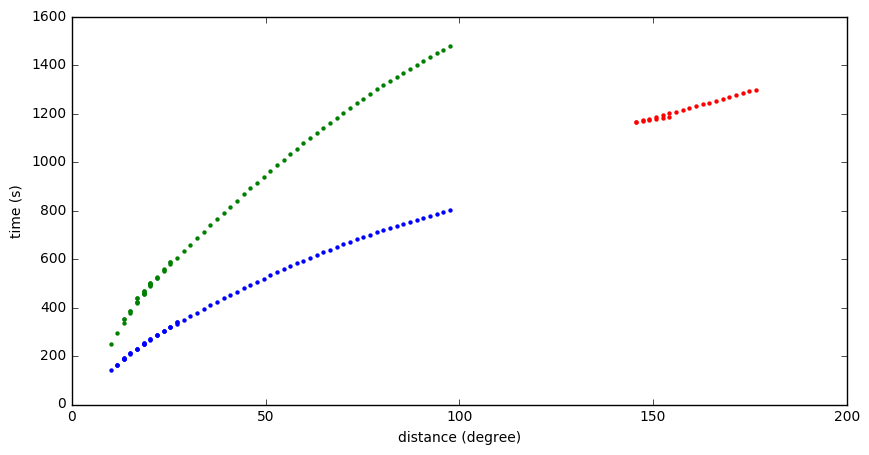

In [11]:
distances = np.linspace(10, 180, 100)
fig, ax = plt.subplots(figsize=(10, 5))


phases = ["P", "PKP", "S"]
colors = {"P":"b", "PKP":"r", "S":"g"}

for i, value in enumerate(distances):
    arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                    distance_in_degree=value,
                                    phase_list=phases)
    if len(arrivals)==0: continue
    for arrival in arrivals:
        #print(arrival.phase.name)
        ax.scatter(value,arrival.time, c=colors[arrival.phase.name], s=10, linewidth=0)
        
ax.set_ylabel("time (s)")
ax.set_xlabel("distance (degree)")

Mais donc, comment la graine a-t-elle été découverte? Par une sismologue danoise qui a détecté des ondes P dans la zone d'ombre.

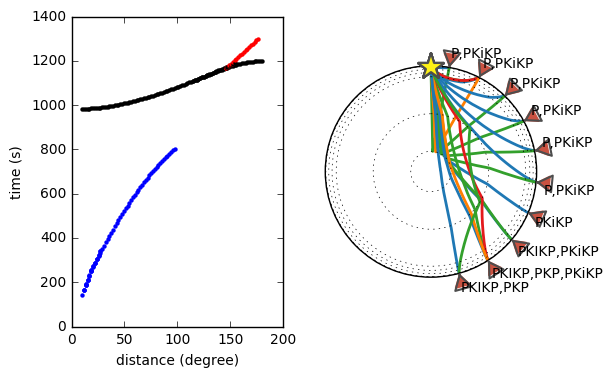

In [19]:
distances = np.linspace(10, 180, 100)
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)

phases = ["P", "PKP", "PKiKP", "PKIKP"]
colors = {"P":"b", "PKP":"r", "S":"g", "PKiKP":"k", "PKIKP":"k"}

for i, value in enumerate(distances):
    arrivals = model.get_travel_times(source_depth_in_km=source_depth,
                                    distance_in_degree=value,
                                    phase_list=phases)
    if len(arrivals)==0: continue
    for arrival in arrivals:
        #print(arrival.phase.name)
        ax1.scatter(value,arrival.time, c=colors[arrival.phase.name], s=10, linewidth=0)
        
ax1.set_ylabel("time (s)")
ax1.set_xlabel("distance (degree)")

for i, value in enumerate(distances[::10]):
    arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                    distance_in_degree=value,
                                    phase_list=phases)
    if len(arrivals)==0: continue
    arrivals.plot(ax=ax2,plot_type='spherical', legend=False, label_arrivals=True,
                  show=False)

Et si on regarde un point dans la zone d'ombre:

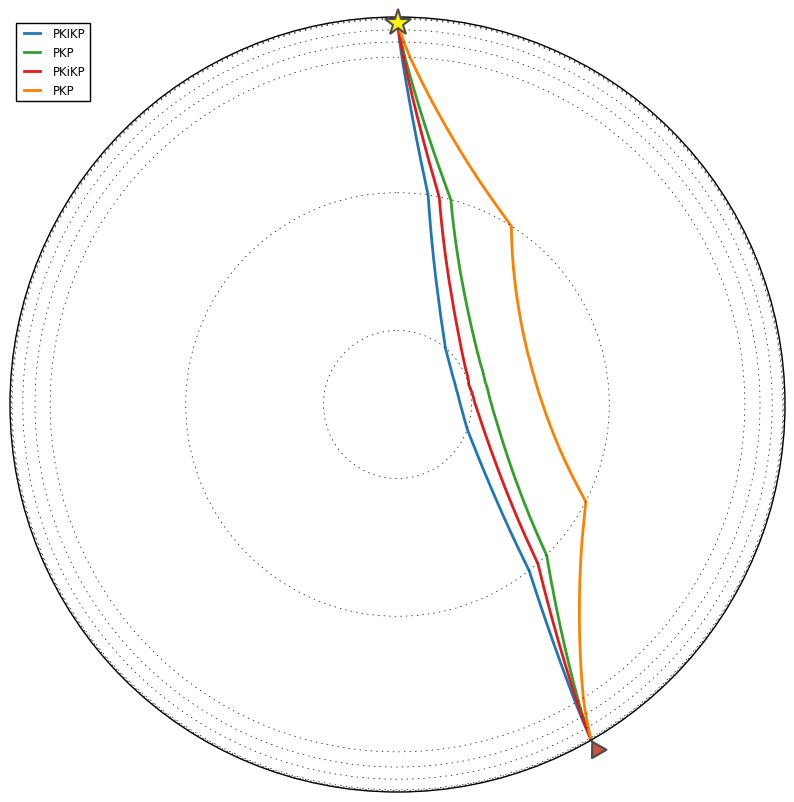

In [30]:
distances = [150]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
phases = ['P','PKP','PKIKP','PKiKP']

last=False
for i, value in enumerate(distances):
    arrivals = model.get_ray_paths(source_depth_in_km=source_depth,
                                   distance_in_degree=value,
                                   phase_list=phases)
    if len(arrivals)==0:
        if last == False:
            last = True
            print("La dernière observation d'onde {} était à la station {} degrés.".format(phases,distances[i-1]))
        print("Pas de détection d'onde {} à la station située à {} degrés.".format(phases, value))
        continue
    arrivals.plot(plot_type='spherical',
                  legend=True, 
                  label_arrivals=False,
                  show=False, ax=ax)

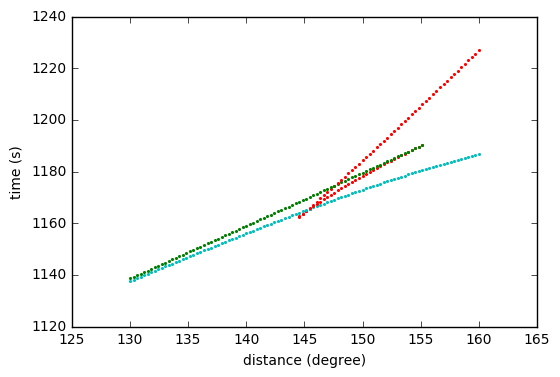

In [29]:
distances = np.linspace(130, 160, 100)
fig = plt.figure()
ax = plt.subplot(111)

phases = ["P", "PKP", "PKiKP", "PKIKP"]
colors = {"P":"b", "PKP":"b", "PKiKP":"orange", "PKIKP":"red"}

for i, value in enumerate(distances):
    arrivals = model.get_travel_times(source_depth_in_km=source_depth,
                                    distance_in_degree=value,
                                    phase_list=phases)
    if len(arrivals)==0: continue
    for arrival in arrivals:
        #print(arrival.phase.name)
        ax.scatter(value,arrival.time, c=colors[arrival.phase.name], s=5, linewidth=0)
        
ax.set_ylabel("time (s)")
ax.set_xlabel("distance (degree)")

Sur cette figure, on voit les multiples arrivées entre 145 et 155 degrés.